In [ ]:
from time import time
import copy
import math

import torch
import torch_geometric
import GNNTrackingTools as GTT

from torch import optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import random_split

from torch_geometric.data import Data, DataLoader, InMemoryDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

/opt/anaconda3/envs/PyG/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Read data file
df = pd.read_pickle("/Users/mghrear/data/LDMX_GNN/test_8gev_electrons_withTracking_30000_MG_5e.pkl")
# Compute Info needed to build graphs
# The only argument is the number of primaries simulated, this is only needed for label building 
df[['edge_index_0', 'edge_index_1', 'edge_feat_0', 'edge_feat_1', 'edge_feat_2','edge_label']]  = df.apply(GTT.GetGraphInfo, axis=1, args=(5,), result_type='expand')

df.head()

,x,y,z,E,ID,Digi_x,Digi_y,Digi_z,Digi_E,Digi_ID
0,"[-6.1657863, -6.2280884, -7.4651546, -7.560230...","[-26.481228, -26.48133, -26.482199, -26.48193,...","[-615.5, -609.5, -515.5, -509.5, -415.5, -409....","[0.15620436, 0.09997243, 0.09009961, 0.0926791...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, ...","[-615.5, -615.5, -615.5, -615.5, -615.5, -609....","[1.942004, -4.2444515, -6.6921215, -2.1466496,...","[36.903976, 6.743964, 9.547099, 39.559414, -26...","[0.12266732, 0.08207677, 0.09806152, 0.0929563...","[1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, ..."
1,"[5.8142776, 5.7514205, 4.5055604, 4.5030046, 4...","[-4.253759, -4.2534556, -4.236259, -4.2362294,...","[-615.5, -609.5, -515.5791, -515.4191, -509.5,...","[0.07235471, 0.10053486, 0.058452714, 0.059001...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[-615.5, -615.5, -615.5, -615.5, -609.5, -609....","[-4.839602, 3.0073886, -5.221901, 5.824609, -4...","[-27.322662, -23.766891, 26.10426, -4.253757, ...","[0.09350429, 0.096878454, 0.1438558, 0.0723547...","[1, 2, 4, 5, 1, 2, 4, 5, 1, 2, 3, 4, 5, 1, 2, ..."
2,"[4.213131, 4.150041, 2.8889322, 2.7915063, 1.0...","[8.289397, 8.288871, 8.295825, 8.296521, 8.311...","[-615.5, -609.5, -515.5, -509.5, -415.5, -409....","[0.07305303, 0.17275162, 0.11246147, 0.0963572...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, ...","[-615.5, -615.5, -615.5, -615.5, -615.5, -609....","[5.7180843, 4.361154, 6.098156, 5.341816, 4.20...","[10.532579, 36.32064, -5.2584414, -24.705404, ...","[0.09474933, 0.09941378, 0.09285116, 0.1370235...","[1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, ..."
3,"[-8.000728, -8.063659, -9.310697, -9.40709, -1...","[-3.1684225, -3.1680837, -3.1666994, -3.166406...","[-615.5, -609.5, -515.5, -509.5, -415.5, -409....","[0.117367506, 0.11546926, 0.08352268, 0.133953...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, ...","[-615.5, -615.5, -615.5, -615.5, -609.5, -609....","[-6.8064766, 6.3133793, 5.9136863, -7.9964857,...","[-6.545982, -9.411359, -32.969704, -3.1684217,...","[0.11394499, 0.08193731, 0.11419299, 0.1173675...","[1, 2, 4, 5, 1, 2, 5, 1, 2, 3, 4, 5, 1, 2, 3, ..."
4,"[-0.31027097, -0.37312007, -1.6195923, -1.7161...","[-38.296078, -38.296215, -38.2967, -38.29707, ...","[-615.5, -609.5, -515.5, -509.5, -415.5, -409....","[0.1169872, 0.085270055, 0.09562814, 0.5204493...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, ...","[-615.5, -615.5, -615.5, -615.5, -615.5, -609....","[-5.952578, -6.0068917, -10.583366, -5.306094,...","[-32.221752, -22.433867, -14.395233, -34.41126...","[0.09708474, 0.103494875, 0.097312994, 0.15282...","[1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, ..."


/Users/mghrear/Lab/LDMX/GNN-tracking-ldmx/GNNTrackingTools.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  x = torch.Tensor([self.df.Digi_x[idx], self.df.Digi_y[idx], self.df.Digi_z[idx]]).T


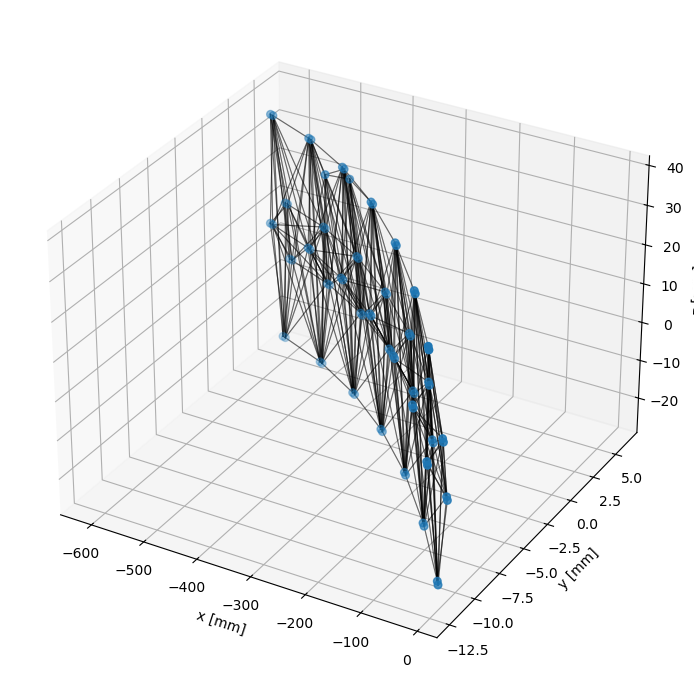

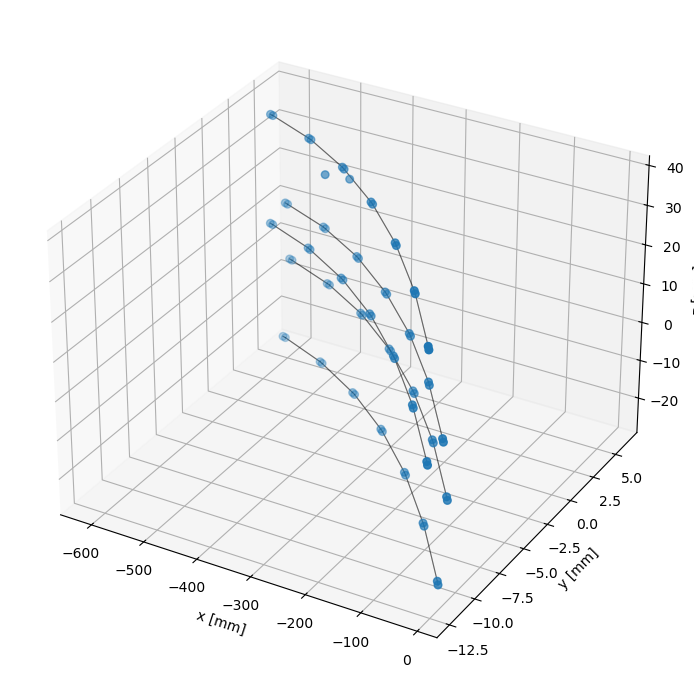

In [3]:
# Make GNN dataset
dataset = GTT.MyInMemoryDataset(df, n_primaries = 5, mode = "EC")

# Plot example graph
data = dataset[2]
GTT.plot_pyg_graph_3d(data, plot_truth=True)

In [4]:
# Split into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(42) )

# Make DataLoaders
batch_size = 30
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_47993/2210891527.py:6: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_47993/2210891527.py:7: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_47993/2210891527.py:8: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Initialize Model and Optimizer

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
# Initialize model
hidden_size = 40


model = GTT.InteractionNetwork(hidden_size).to(device)
total_trainable_params = sum(p.numel() for p in model.parameters())
print(f"Total trainable parameters: {total_trainable_params}")

Total trainable parameters: 6287


In [7]:
# Initialize optimizer

lr = 5E-3
step_size = 5
gamma = 0.9

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# Train the model

In [ ]:
epochs = 5

best_val_loss = math.inf
best_thld = None
best_state_dict = None  # or best_model = None

output = {'train_loss': [], 'val_loss': [], 'optimal_thld': []}

for epoch in range(1, epochs + 1):
    print(f"---- Epoch {epoch} ----")
    train_loss = GTT.train(model, device, train_loader, optimizer, epoch)
    thld, val_loss = GTT.validate(model, device, val_loader)
    print('...optimal threshold', thld)

    # keep best model (lowest val loss) + its threshold
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_thld = thld
        best_state_dict = copy.deepcopy(model.state_dict())  # safest/common

    scheduler.step()

    output['train_loss'].append(train_loss)
    output['val_loss'].append(val_loss)
    output['optimal_thld'].append(thld)


    


---- Epoch 1 ----
...epoch time: 13.607919931411743s
...epoch 1: train loss=0.08281024479174189
...val accuracy= 0.9952830585477835
...val loss= 0.02069028825809558
...optimal threshold 0.4214800000000001
...test loss: 0.0207
...test accuracy: 0.9954
---- Epoch 2 ----
...epoch time: 13.684967994689941s
...epoch 2: train loss=0.03026768566175763
...val accuracy= 0.9962390790338751
...val loss= 0.016374359636877975
...optimal threshold 0.33076000000000005
...test loss: 0.0160
...test accuracy: 0.9964
---- Epoch 3 ----
...epoch time: 13.655971765518188s
...epoch 3: train loss=0.025653311602571713
...val accuracy= 0.9966148404663996
...val loss= 0.013524867522840699
...optimal threshold 0.3281066666666666
...test loss: 0.0137
...test accuracy: 0.9966
---- Epoch 4 ----
...epoch time: 13.701364994049072s
...epoch 4: train loss=0.0204932052336101
...val accuracy= 0.9969611470070305
...val loss= 0.011209552969473104
...optimal threshold 0.28569333333333335
...test loss: 0.0112
...test accuracy

In [ ]:
# convert output to pandas DataFrame and save as pickle
output_df = pd.DataFrame(output)
output_df.to_pickle("LDMX_IN_training_output.pkl")

In [ ]:
# Plot the training and validation losses

plt.plot(np.arange(len(output_df))+1,output_df.train_loss,label='Training')
plt.plot(np.arange(len(output_df))+1,output_df.val_loss,label='Validation')
plt.axvline(x=np.argmin(output_df['val_loss'])+1, linestyle='--', color='k', label='Final Model')


plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()


# Test the final model

In [ ]:
# later, restore best model + use best_thld
model.load_state_dict(best_state_dict)
thld = best_thld

test_loss, test_acc = GTT.test(model, device, test_loader, thld=thld)

print("test loss = ", test_loss)
print("test acc = ", test_acc)


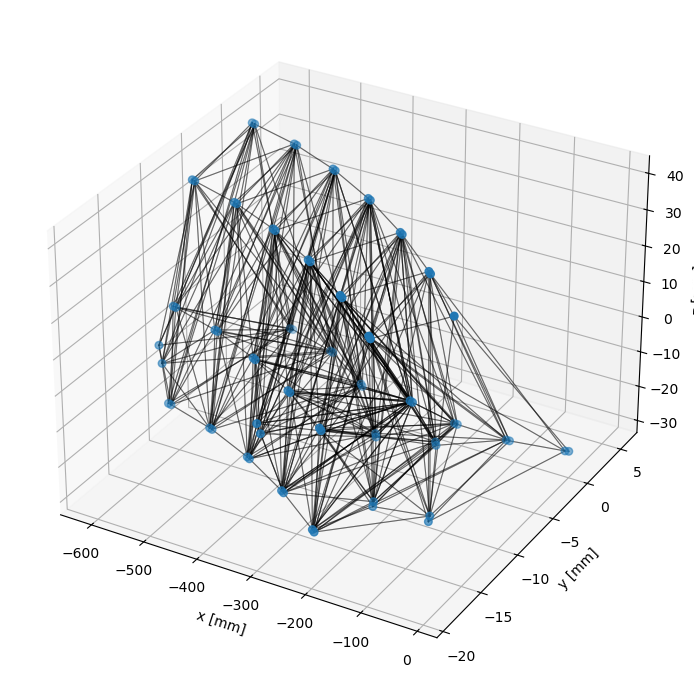

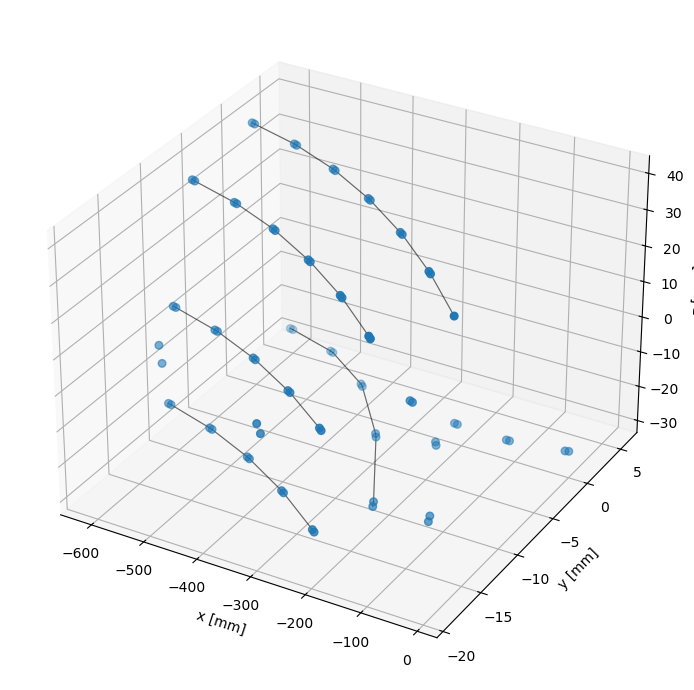

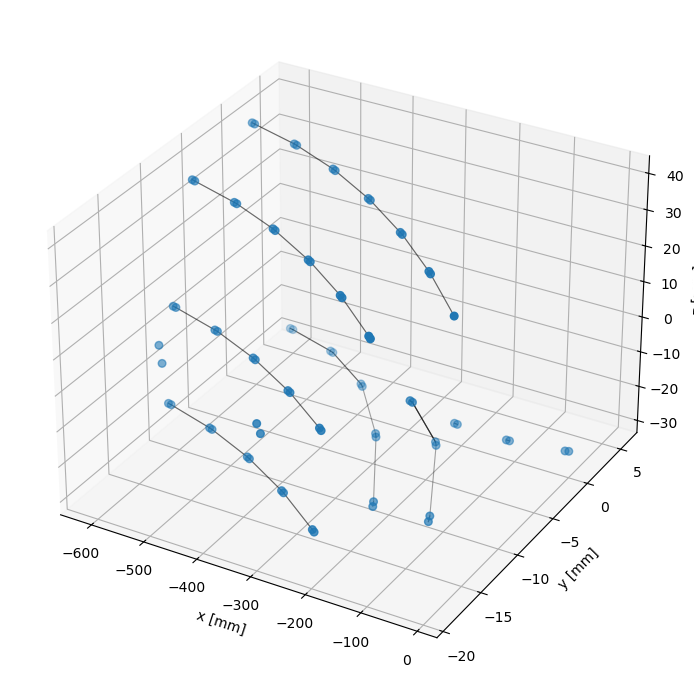

In [11]:
graph = test_dataset[0]
graph

# Analyze graph with model
model.eval()
data = graph.to(device)
output = model(data.x, data.edge_index, data.edge_attr).squeeze(1).detach().cpu()
graph.pred = output>thld


GTT.plot_pyg_graph_3d(data, plot_truth=True, plot_pred=True)

In [ ]:
# Run track building 

test_tracks = GTT.PrimitiveTrackBuilder(model, device, test_loader, thld=0.5, min_nodes =4)
test_tracks.head()